# Imports

In [1]:
import os, platform

local = platform.system() == 'Windows'

if local:
	print('Running Locally')
	workspace_dir = './'
else:
	!pip install qqdm

	from google.colab import drive
	drive.mount('/content/drive/')

	workspace_dir = '/content/drive/MyDrive/School/2022_RIT/Masters/Workspace/'
	print('Running in Google Colab')

Running Locally


In [2]:
import random

from qqdm.notebook import qqdm as qqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset, Dataset)
from torch.optim import Adam

from scipy.stats import mstats

## Model

In [3]:
class IDS_VAE(nn.Module):
	def __init__(self, latent_dim, KL_weight):
		super(IDS_VAE, self).__init__()

		self.latent_dim = latent_dim
		self.KL_weight = KL_weight

		self.criterion = nn.MSELoss()

		self.channel_dims = [1, 32, 64]

		#====================[Encoder]====================
		self.encoder = nn.Sequential(
			nn.Conv2d(                                                                #in: N*1*8*8, out: N*dim[1]*4*4
				in_channels=self.channel_dims[0], out_channels=self.channel_dims[1],
				kernel_size=3, stride=2, padding=1
			),
			nn.BatchNorm2d(self.channel_dims[1]),                                     #in and out: N*dim[1]*4*4
			nn.LeakyReLU(),                                                           #in and out: N*dim[1]*4*4
			nn.Conv2d(                                                                #in: N*dim[1]*4*4, out: N*dim[2]*2*2
				in_channels=self.channel_dims[1], out_channels=self.channel_dims[2],
				kernel_size=3, stride=2, padding=1
			),
			nn.BatchNorm2d(self.channel_dims[2]),                                     #in and out: N*dim[2]*2*2
			nn.LeakyReLU()                                                            #in and out: N*dim[2]*2*2
		)

		#====================[Reparametrize]====================
		self.mu_layer  = nn.Linear(self.channel_dims[2]*2*2, self.latent_dim)         #in: N*1*(dim[2]*4)*1, out: N*1*latent_dim*1
		self.var_layer = nn.Linear(self.channel_dims[2]*2*2, self.latent_dim)         #in: N*1*(dim[2]*4)*1, out: N*1*latent_dim*1

		#====================[Decode]====================
		self.decode_linear_input = nn.Linear(                                         #in: N*1*latent_dim*1, out: N*1*(dim[2]*4)*1
			in_features=self.latent_dim, out_features=self.channel_dims[2]*2*2
		)


		self.decoder = nn.Sequential(
			nn.ConvTranspose2d(                                                       #in: N*dim[2]*2*2, out: N*dim[1]*4*4
				in_channels=self.channel_dims[2], out_channels=self.channel_dims[1],
				kernel_size=3, stride=2, padding=1, output_padding=1
			),
			nn.BatchNorm2d(self.channel_dims[1]),                        #in and out: N*dim[1]*4*4
			nn.LeakyReLU(),                                                             #in and out: N*dim[1]*4*4
			nn.ConvTranspose2d(                                                       #in: N*dim[1]*4*4, out: N*dim[1]*8*8
				in_channels=self.channel_dims[1], out_channels=self.channel_dims[1],
				kernel_size=3, stride=2, padding=1, output_padding=1
			),
			nn.BatchNorm2d(self.channel_dims[1]),                        #in and out: N*dim[1]*8*8
			nn.LeakyReLU(),                                                           #in and out: N*dim[1]*8*8
			nn.Conv2d(                                                                #in: N*dim[1]*8*8, out: N*1*8*8
				in_channels=self.channel_dims[1], out_channels=self.channel_dims[0],
				kernel_size=3, padding=1
			),
			##nn.Tanh()                                                                 #in and out: N*1*8*8
			nn.Sigmoid()
		)
	
	def encode(self, x):
		result = self.encoder(x)
		result = torch.flatten(result, start_dim=1)

		return result
	
	def reparameterize(self, x):
		mu = self.mu_layer(x)
		var = self.var_layer(x)

		std = torch.exp(0.5 * var)
		eps = torch.randn_like(std)
		return (eps * std) + mu, mu, var
	
	def decode(self, x):
		result = self.decode_linear_input(x)
		result = result.view(-1, self.channel_dims[2], 2, 2)
		result = self.decoder(result)
		return result
	
	def forward(self, x):
		encoded_output = self.encode(x)
		reparameterized_output, mu, var = self.reparameterize(encoded_output)
		decoded_output = self.decode(reparameterized_output)
		return encoded_output, reparameterized_output, mu, var, decoded_output

	def loss(self, output, input, mu, var):
		mse_loss = self.criterion(output, input)

		KL_loss = torch.mean(-0.5 * torch.sum(1 + var - mu**2 - var.exp(), dim=1), dim=0)

		loss = mse_loss + self.KL_weight * KL_loss

		return loss, mse_loss, KL_loss

# Pre-Processing

In [36]:
# def winsorize_col(df: pd.DataFrame, )
def print_col_stats(df, col):
	print(f'Column \'{col}\' stats:')
	print(f'\tmin:  {df[col].min()}')
	print(f'\tmean: {df[col].mean()}')
	print(f'\tmax:  {df[col].max()}')

def get_index_of_first_val(df, col, val):
	# df['Marks'][df['Marks'] == 99].index.tolist()
	indexes = df[col][df[col] == val].index.tolist()
	if len(indexes) > 0:
		return indexes[0]
	else:
		return None

def new_normalization(df: pd.DataFrame, cols_to_normalize: list, debug=False):
	print('=====[Performing winsorization and normalization]=====')
	for col in cols_to_normalize:
		neg_inf_idx = df[col][df[col] == float('-inf')].index.tolist() # get_index_of_first_val(df, col, float('-inf'))
		inf_idx = df[col][df[col] == float('inf')].index.tolist() # get_index_of_first_val(df, col, float('inf'))
		nan_idx = df[col][df[col] == float('nan')].index.tolist() # get_index_of_first_val(df, col, float('nan'))
		if len(neg_inf_idx) > 0:
			print('#-inf:', len(neg_inf_idx))
		if len(inf_idx) > 0:
			print('#inf:', len(inf_idx))
		if len(nan_idx) > 0:
			print('#nan:', len(nan_idx))
		
		if debug:print_col_stats(df, col)
		print(f'Winsorizing column \'{col}\'')

		df[col] = mstats.winsorize(df[col], limits=[0.05, 0.05])
		if debug:print_col_stats(df, col)

		if len(neg_inf_idx) > 0:
			print('-inf value:', df[col][neg_inf_idx[0]])
		if len(inf_idx) > 0:
			print('inf value:', df[col][inf_idx[0]])
		if len(nan_idx) > 0:
			print('nan value:', df[col][nan_idx[0]])
  
		if debug:print('Min Max Scaling to [0,1]')
		width = df[col].max() - df[col].min()
		if width == 0.0:
			print(f'Zero width column: \'{col}\'')
			width = 1
		df[col] = ( df[col] - df[col].min() ) / ( width )
		if debug:print_col_stats(df, col)
		if debug:print('')

		if len(neg_inf_idx) > 0:
			print('-inf value:', df[col][neg_inf_idx[0]])
		if len(inf_idx) > 0:
			print('inf value:', df[col][inf_idx[0]])
		if len(nan_idx) > 0:
			print('nan value:', df[col][nan_idx[0]])

	return df

def freq_encode_cols(df: pd.DataFrame, cols_to_encode: list, debug=False):
	print('=====[Performing frequency encoding]=====')
	for col in cols_to_encode:
		if debug: print(f'Frequency encoding column {col}\n')
		val_counts = df[col].value_counts(normalize=True)
		if debug: print('Value counts:\n', val_counts, '\n')
  
		replace_dict = {}

		for idx in val_counts.index:
			replace_dict[idx] = val_counts[idx]
		
		if debug: print('Replace Dict:', replace_dict)
		df = df.replace({col: replace_dict})

		if debug:
			unique_values = df[col].unique()
			print('Unique Values:', unique_values, '\n')

		return df
		


def new_load_CSV(filename):
	#Read CSV file
	print(f'Loading CSV: {filename}')
	df = pd.read_csv(filename)

	#Remove cols
	cols_to_remove = ['Dst Port', 'Timestamp']
	df = df.drop(cols_to_remove, axis=1)
	print(f'Dropped columns: {cols_to_remove}')

	#'Dst Port' cleaning
	# df[df['Dst Port'] > 49151] = 49152
	# print('value counts\n', df['Dst Port'].value_counts())

	print(f'Columns: {df.columns}')
 
	cols_to_encode = ['Protocol']
	df = freq_encode_cols(df, cols_to_encode)
 
	print('non numeric:')
	print(df.dtypes)
	# for i in range(1000000):
	# 	if not isinstance(df['Flow Duration'][i], (float, int)):
	# 		print(i,[df['Flow Duration'][i]])
	# df = df.astype({'Flow Duration':'float'})
	# print(df['Flow Duration'].describe())
	# return None
 
	cols_to_normalize = [
		'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
		'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 
		'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 
		'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
		'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 
		'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 
		'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 
		'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 
		'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len',
		'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
		'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
		'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
		'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
		'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
		'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg',
		'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg',
		'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts',
		'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts',
		'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min',
		'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
		'Idle Std', 'Idle Max', 'Idle Min'
	]
	df = new_normalization(df, cols_to_normalize, False)

	return df


In [11]:
Student_dict = {
    'Name': ['Jack', 'Rack', 'Max', 'David'],
    'Marks':[99,98, 100,100],
    'Subject': ['Math', 'Math', 'Music', 'Physic']
}
   
df = pd.DataFrame(Student_dict)
print(df.Marks[df.Marks == 999].index.tolist())
print(df['Marks'][df['Marks'] == 99].index.tolist())

[]
[0]


In [40]:
files = [
    'CIC-IDS-2018/02-14-2018.csv',
    'CIC-IDS-2018/02-15-2018.csv',
    'CIC-IDS-2018/02-16-2018.csv',
    'CIC-IDS-2018/02-21-2018.csv',
    'CIC-IDS-2018/02-22-2018.csv',
    'CIC-IDS-2018/02-23-2018.csv',
    'CIC-IDS-2018/02-28-2018.csv',
    'CIC-IDS-2018/03-01-2018.csv',
    'CIC-IDS-2018/03-02-2018.csv'
]

In [60]:
for f in files:
    df = pd.read_csv(f)
    for label in df['Label'].unique():
        print(f)
        print(f'\t{label}')
        dfl = df[df['Label'] == label]
        pd.options.mode.use_inf_as_na = True
        neg_inf_idx = dfl[dfl.isnull().any(axis=1)].index.tolist()
        print(f'\t\tBad vals: {len(neg_inf_idx)}')
    print('')

CIC-IDS-2018/02-14-2018.csv
	Benign
		Bad vals: 3818
CIC-IDS-2018/02-14-2018.csv
	FTP-BruteForce
		Bad vals: 6
CIC-IDS-2018/02-14-2018.csv
	SSH-Bruteforce
		Bad vals: 0

CIC-IDS-2018/02-15-2018.csv
	Benign
		Bad vals: 8027
CIC-IDS-2018/02-15-2018.csv
	DoS attacks-GoldenEye
		Bad vals: 0
CIC-IDS-2018/02-15-2018.csv
	DoS attacks-Slowloris
		Bad vals: 0

CIC-IDS-2018/02-16-2018.csv
	Benign
		Bad vals: 0
CIC-IDS-2018/02-16-2018.csv
	DoS attacks-SlowHTTPTest
		Bad vals: 0
CIC-IDS-2018/02-16-2018.csv
	DoS attacks-Hulk
		Bad vals: 0

CIC-IDS-2018/02-21-2018.csv
	Benign
		Bad vals: 0
CIC-IDS-2018/02-21-2018.csv
	DDOS attack-LOIC-UDP
		Bad vals: 0
CIC-IDS-2018/02-21-2018.csv
	DDOS attack-HOIC
		Bad vals: 0

CIC-IDS-2018/02-22-2018.csv
	Benign
		Bad vals: 5610
CIC-IDS-2018/02-22-2018.csv
	Brute Force -Web
		Bad vals: 0
CIC-IDS-2018/02-22-2018.csv
	Brute Force -XSS
		Bad vals: 0
CIC-IDS-2018/02-22-2018.csv
	SQL Injection
		Bad vals: 0

CIC-IDS-2018/02-23-2018.csv
	Benign
		Bad vals: 5708
CIC-IDS-

## Load file

In [53]:
filename = '02-14-2018.csv'

In [54]:
data = new_load_CSV(workspace_dir + 'CIC-IDS-2018/' + filename)

Loading CSV: ./CIC-IDS-2018/02-14-2018.csv
Dropped columns: ['Dst Port', 'Timestamp']
Columns: Index(['Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CW

## Save Class-wise Files

In [ ]:
print(data['Label'].value_counts())
for label in data['Label'].unique():
    subdata = data[data['Label'] == label]
    print(f'Outputting subdata file:', workspace_dir + 'CIC-IDS-2018/class_split/' + filename[:-4] + '-' + label + '.csv')
    subdata.to_csv(workspace_dir + 'CIC-IDS-2018/class_split/' + filename[:-4] + '-' + label + '.csv')

Benign    762384
Bot       286191
Name: Label, dtype: int64
Outputting subdata file: /content/drive/MyDrive/School/2022_RIT/Masters/Workspace/CIC-IDS-2018/class_split/03-02-2018-Benign.csv
Outputting subdata file: /content/drive/MyDrive/School/2022_RIT/Masters/Workspace/CIC-IDS-2018/class_split/03-02-2018-Bot.csv


Emojis: ✅ ❌

| Completed | Column | Notes|
|-|-|-|
| ✅ | Protocol | Frequency |
| ✅ | Flow Duration | Normalization |
| ✅ | Tot Fwd Pkts | Normalization |
| ✅ | Tot Bwd Pkts | Normalization |
| ✅ | TotLen Fwd Pkts | Normalization |
| ✅ | TotLen Bwd Pkts | Normalization |
| ✅ | Fwd Pkt Len Max | Normalization |
| ✅ | Fwd Pkt Len Min | Normalization |
| ✅ | Fwd Pkt Len Mean | Normalization |
| ✅ | Fwd Pkt Len Std | Normalization |
| ✅ | Bwd Pkt Len Max | Normalization |
| ✅ | Bwd Pkt Len Min | Normalization |
| ✅ | Bwd Pkt Len Mean | Normalization |
| ✅ | Bwd Pkt Len Std | Normalization |
| ✅ | Flow Byts/s | Normalization |
| ✅ | Flow Pkts/s | Normalization |
| ✅ | Flow IAT Mean | Normalization |
| ✅ | Flow IAT Std | Normalization |
| ✅ | Flow IAT Max | Normalization |
| ✅ | Flow IAT Min | Normalization |
| ✅ | Fwd IAT Tot | Normalization |
| ✅ | Fwd IAT Mean | Normalization |
| ✅ | Fwd IAT Std | Normalization |
| ✅ | Fwd IAT Max | Normalization |
| ✅ | Fwd IAT Min | Normalization |
| ✅ | Bwd IAT Tot | Normalization |
| ✅ | Bwd IAT Mean | Normalization |
| ✅ | Bwd IAT Std | Normalization |
| ✅ | Bwd IAT Max | Normalization |
| ✅ | Bwd IAT Min | Normalization |
| ✅ | Fwd PSH Flags | Normalization |
| ✅ | Bwd PSH Flags | Normalization |
| ✅ | Fwd URG Flags | Normalization |
| ✅ | Bwd URG Flags | Normalization |
| ✅ | Fwd Header Len | Normalization |
| ✅ | Bwd Header Len | Normalization |
| ✅ | Fwd Pkts/s | Normalization |
| ✅ | Bwd Pkts/s | Normalization |
| ✅ | Pkt Len Min | Normalization |
| ✅ | Pkt Len Max | Normalization |
| ✅ | Pkt Len Mean | Normalization |
| ✅ | Pkt Len Std | Normalization |
| ✅ | Pkt Len Var | Normalization |
| ✅ | FIN Flag Cnt | Normalization |
| ✅ | SYN Flag Cnt | Normalization |
| ✅ | RST Flag Cnt | Normalization |
| ✅ | PSH Flag Cnt | Normalization |
| ✅ | ACK Flag Cnt | Normalization |
| ✅ | URG Flag Cnt | Normalization |
| ✅ | CWE Flag Count | Normalization |
| ✅ | ECE Flag Cnt | Normalization |
| ✅ | Down/Up Ratio | Normalization |
| ✅ | Pkt Size Avg | Normalization |
| ✅ | Fwd Seg Size Avg | Normalization |
| ✅ | Bwd Seg Size Avg | Normalization |
| ✅ | Fwd Byts/b Avg | Normalization |
| ✅ | Fwd Pkts/b Avg | Normalization |
| ✅ | Fwd Blk Rate Avg | Normalization |
| ✅ | Bwd Byts/b Avg | Normalization |
| ✅ | Bwd Pkts/b Avg | Normalization |
| ✅ | Bwd Blk Rate Avg | Normalization |
| ✅ | Subflow Fwd Pkts | Normalization |
| ✅ | Subflow Fwd Byts | Normalization |
| ✅ | Subflow Bwd Pkts | Normalization |
| ✅ | Subflow Bwd Byts | Normalization |
| ✅ | Init Fwd Win Byts | Normalization |
| ✅ | Init Bwd Win Byts | Normalization |
| ✅ | Fwd Act Data Pkts | Normalization |
| ✅ | Fwd Seg Size Min | Normalization |
| ✅ | Active Mean | Normalization |
| ✅ | Active Std | Normalization |
| ✅ | Active Max | Normalization |
| ✅ | Active Min | Normalization |
| ✅ | Idle Mean | Normalization |
| ✅ | Idle Std | Normalization |
| ✅ | Idle Max | Normalization |
| ✅ | Idle Min | Normalization |
|  | Label |  |

# Model Training

## Dataset Class

In [80]:
class IDS_Dataset(Dataset):
    def __init__(this, filename):
        this.data = pd.read_csv(filename)
        this.labels = this.data['Label']
        this.data = this.data.drop([
            'Unnamed: 0', 'Protocol', 'Bwd PSH Flags', 'Fwd URG Flags', 
            'Bwd URG Flags', 'FIN Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 
            'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 
            'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Label'
        ], axis=1)
        this.data = torch.tensor(this.data.values, dtype=torch.float32)
    
    def __len__(this):
        return this.data.size(0)
    
    def __getitem__(this, idx):
        row = this.data[idx]
        label = this.labels[idx]
        return row, label

In [72]:
data = IDS_Dataset(workspace_dir + 'CIC-IDS-2018/class_split/d02-14-2018-Benign.csv')

In [ ]:
len(data[0][0])

64

In [91]:
loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

## Training

In [85]:
learning_rate = 1e-3

model = IDS_VAE(latent_dim=5, KL_weight=0.05).cuda()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

In [92]:
epochs = 1

first_print = True

# progbar = qqdm(range(epochs))
# for epoch in progbar:
for epoch in range(epochs):
    # progbar = qqdm(loader)
    # for data in progbar:
    # for data in loader: #progbar:
        # print(data[1])

    progbar = qqdm(range(100))
    for i in progbar:
        data = next(iter(loader))
        if first_print:
            first_print = False
            print(data[1].size())
        x = data[1].view(-1, 1, 8, 8).cuda()
        encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
        loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progbar.set_infos({
            'epoch': f'{epoch+1}',
            'loss': f'{losses[-1]}'
        })

  Iters     Elapsed Time       Speed     epoch         loss                     
 100/100  00:00:00<00:00:00  151.51it/s    1    0.08265243470668793             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

torch.Size([64, 64])


## Plot Loss

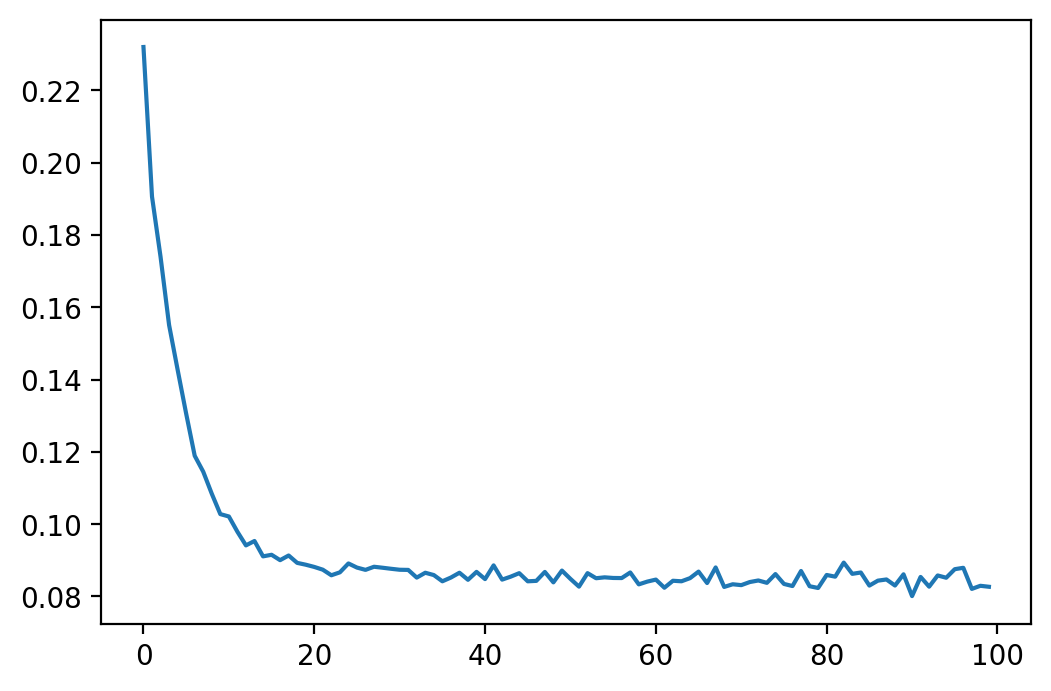

In [93]:
plt.figure(dpi=200)
plt.plot(losses)

# Save Model

In [ ]:
torch.save(model, './30-6-0001.pth')

In [ ]:
model = torch.load('./19-2-0006-50-35-5.pth')
model.eval()

WeirdTrafficNet(
  (encoder): Sequential(
    (0): Linear(in_features=63, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=35, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=35, out_features=5, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=35, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=35, out_features=50, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=50, out_features=63, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
def read_number_lines(filename):
	# print('Trying to read file')
	# print('OG file:',filename)
	# print('New filename:', filename.replace("\\", '/'))
	df = pd.read_csv(filename.replace('\\', '/'))
	print(f'{len(df.index)} entries in {filename}\n')

In [ ]:
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d03-01-2018-Benign.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-28-2018-Infilteration.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-28-2018-Benign.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-23-2018-SQL Injection.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-23-2018-Brute Force -XSS.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-23-2018-Brute Force -Web.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-23-2018-Benign.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-22-2018-SQL Injection.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-22-2018-Brute Force -XSS.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-22-2018-Brute Force -Web.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-22-2018-Benign.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-21-2018-DDOS attack-LOIC-UDP.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-21-2018-DDOS attack-HOIC.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-21-2018-Benign.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-16-2018-DoS attacks-SlowHTTPTest.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-16-2018-DoS attacks-Hulk.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-16-2018-Benign.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-15-2018-DoS attacks-Slowloris.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-15-2018-DoS attacks-GoldenEye.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-15-2018-Benign.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-14-2018-SSH-Bruteforce.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-14-2018-FTP-BruteForce.csv')
# read_number_lines(workspace_dir + 'CIC-IDS-2018\class_split\d02-14-2018-Benign.csv')

CIC_2017_files = [
    'daMonday-WorkingHours-BENIGN.csv',
    'dbTuesday-WorkingHours-BENIGN.csv',
    'dbTuesday-WorkingHours-FTP-Patator.csv',
    'dbTuesday-WorkingHours-SSH-Patator.csv',
    'dcWednesday-workingHours-BENIGN.csv',
    'dcWednesday-workingHours-DoS GoldenEye.csv',
    'dcWednesday-workingHours-DoS Hulk.csv',
    'dcWednesday-workingHours-DoS Slowhttptest.csv',
    'dcWednesday-workingHours-DoS slowloris.csv',
    'dcWednesday-workingHours-Heartbleed.csv',
    'ddThursday-WorkingHours-Morning-WebAttacks-BENIGN.csv',
    'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Brute Force.csv',
    'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Sql Injection.csv',
    'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � XSS.csv',
    'deThursday-WorkingHours-Afternoon-Infilteration-BENIGN.csv',
    'deThursday-WorkingHours-Afternoon-Infilteration-Infiltration.csv',
    'dfFriday-WorkingHours-Morning-BENIGN.csv',
    'dfFriday-WorkingHours-Morning-Bot.csv',
    'dgFriday-WorkingHours-Afternoon-DDos-BENIGN.csv',
    'dgFriday-WorkingHours-Afternoon-DDos-DDoS.csv',
    'dgFriday-WorkingHours-Afternoon-PortScan-BENIGN.csv',
    'dgFriday-WorkingHours-Afternoon-PortScan-PortScan.csv'
]

CIC_2018_files = [
    'd02-14-2018-Benign.csv',
    'd02-14-2018-FTP-BruteForce.csv',
    'd02-14-2018-SSH-Bruteforce.csv',
    'd02-15-2018-Benign.csv',
    'd02-15-2018-DoS attacks-GoldenEye.csv',
    'd02-15-2018-DoS attacks-Slowloris.csv',
    'd02-16-2018-Benign.csv',
    'd02-16-2018-DoS attacks-Hulk.csv',
    'd02-16-2018-DoS attacks-SlowHTTPTest.csv',
    'd02-21-2018-Benign.csv',
    'd02-21-2018-DDOS attack-HOIC.csv',
    'd02-21-2018-DDOS attack-LOIC-UDP.csv',
    'd02-22-2018-Benign.csv',
    'd02-22-2018-Brute Force -Web.csv',
    'd02-22-2018-Brute Force -XSS.csv',
    'd02-22-2018-SQL Injection.csv',
    'd02-23-2018-Benign.csv',
    'd02-23-2018-Brute Force -Web.csv',
    'd02-23-2018-Brute Force -XSS.csv',
    'd02-23-2018-SQL Injection.csv',
    'd02-28-2018-Benign.csv',
    'd02-28-2018-Infilteration.csv',
    'd03-01-2018-Benign.csv',
    'd03-01-2018-Infilteration.csv',
    'd03-02-2018-Benign.csv',
    'd03-02-2018-Bot.csv',
]

USB_IDS_files = [
    'Hulk-Evasive-BENIGN.csv',
    'Hulk-Evasive-Hulk-Evasive.csv',
    'Hulk-NoDefense-BENIGN.csv',
    'Hulk-NoDefense-Hulk-NoDefense.csv',
    'Hulk-Reqtimeout-BENIGN.csv',
    'Hulk-Reqtimeout-Hulk-Reqtimeout.csv',
    'Hulk-Security2-BENIGN.csv',
    'Hulk-Security2-Hulk-Security2.csv',
    'REGULAR-BENIGN.csv',
    'Slowhttptest-Evasive-BENIGN.csv',
    'Slowhttptest-Evasive-Slowhttptest-Evasive.csv',
    'Slowhttptest-NoDefense-BENIGN.csv',
    'Slowhttptest-NoDefense-Slowhttptest-NoDefense.csv',
    'Slowhttptest-Reqtimeout-BENIGN.csv',
    'Slowhttptest-Reqtimeout-Slowhttptest-Reqtimeout.csv',
    'Slowhttptest-Security2-BENIGN.csv',
    'Slowhttptest-Security2-Slowhttptest-Security2.csv',
    'Slowloris-Evasive-BENIGN.csv',
    'Slowloris-Evasive-Slowloris-Evasive.csv',
    'Slowloris-NoDefense-BENIGN.csv',
    'Slowloris-NoDefense-Slowloris-NoDefense.csv',
    'Slowloris-Reqtimeout-BENIGN.csv',
    'Slowloris-Reqtimeout-Slowloris-Reqtimeout.csv',
    'Slowloris-Security2-BENIGN.csv',
    'Slowloris-Security2-Slowloris-Security2.csv',
    'TCPFlood-Evasive-BENIGN.csv',
    'TCPFlood-Evasive-TCPFlood-Evasive.csv',
    'TCPFlood-NoDefense-BENIGN.csv',
    'TCPFlood-NoDefense-TCPFlood-NoDefense.csv',
    'TCPFlood-Reqtimeout-BENIGN.csv',
    'TCPFlood-Reqtimeout-TCPFlood-Reqtimeout.csv',
    'TCPFlood-Security2-BENIGN.csv',
    'TCPFlood-Security2-TCPFlood-Security2.csv',
]

for f in USB_IDS_files:
    read_number_lines(workspace_dir + 'USB-IDS\class_split\\' + f)

43 entries in ./USB-IDS\class_split\Hulk-Evasive-BENIGN.csv

756987 entries in ./USB-IDS\class_split\Hulk-Evasive-Hulk-Evasive.csv

41 entries in ./USB-IDS\class_split\Hulk-NoDefense-BENIGN.csv

851132 entries in ./USB-IDS\class_split\Hulk-NoDefense-Hulk-NoDefense.csv

42 entries in ./USB-IDS\class_split\Hulk-Reqtimeout-BENIGN.csv

855631 entries in ./USB-IDS\class_split\Hulk-Reqtimeout-Hulk-Reqtimeout.csv

30 entries in ./USB-IDS\class_split\Hulk-Security2-BENIGN.csv

813048 entries in ./USB-IDS\class_split\Hulk-Security2-Hulk-Security2.csv

305921 entries in ./USB-IDS\class_split\REGULAR-BENIGN.csv

40 entries in ./USB-IDS\class_split\Slowhttptest-Evasive-BENIGN.csv

6692 entries in ./USB-IDS\class_split\Slowhttptest-Evasive-Slowhttptest-Evasive.csv

45 entries in ./USB-IDS\class_split\Slowhttptest-NoDefense-BENIGN.csv

6692 entries in ./USB-IDS\class_split\Slowhttptest-NoDefense-Slowhttptest-NoDefense.csv

44 entries in ./USB-IDS\class_split\Slowhttptest-Reqtimeout-BENIGN.csv

5755 

## Separation Index

$$
\textrm{Separation} = \frac{\textrm{median(target)}-\textrm{median(base)}}{\textrm{base}_{95\%}-\textrm{base}_{5\%}}
$$

In [ ]:
def separation_index(base_losses: list, target_losses: list):
	return (-1*np.median(base_losses) + np.median(target_losses)) / ( np.percentile(base_losses, 95) - np.percentile(base_losses, 5) )

In [ ]:
import pickle
with open('./normalization.data','wb') as f:
	pickle.dump(normalization, f, pickle.HIGHEST_PROTOCOL)